# Clinical Data Processing

## Where the data at?

In [1]:
input_path = '../Data/Intermediate_Files/'
clinical_data_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Processed_Data/'

## Load Methyl Data

In [2]:
import pandas as pd

df_methyl = pd.read_pickle(
    input_path+'2_MethylData_Processing_Output.pkl')

print(
    f' Dataset (df) contains {df_methyl.shape[1]} columns (5mC nucleotides/probes) and {df_methyl.shape[0]} rows (samples).')


 Dataset (df) contains 333352 columns (5mC nucleotides/probes) and 3330 rows (samples).


## Add Labels/Clinical Outcome Data

In [3]:
# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                         labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df_methyl.index)]

## Save each of the labels in excel format
# labels_0531.to_excel(output_path + 'labels_0531.xlsx')
# labels_1031.to_excel(output_path + 'labels_1031.xlsx')
# labels_aml05.to_excel(output_path + 'labels_aml05.xlsx')
# labels_beataml.to_excel(output_path + 'labels_beataml.xlsx')
# labels_amltcga.to_excel(output_path + 'labels_amltcga.xlsx')
# labels_nordic_all.to_excel(output_path + 'labels_nordic_all.xlsx')
# labels_mds_taml.to_excel(output_path + 'labels_mds_taml.xlsx')
# labels_all_graal.to_excel(output_path + 'labels_all_graal.xlsx')
# labels_target_all.to_excel(output_path + 'labels_target_all.xlsx')

### Evaluate Sample Types

In [4]:
df_labels['Sample Type'].value_counts(dropna=False)

Sample Type
Diagnosis                                            2226
Relapse                                               252
Bone Marrow Normal                                    234
Primary Blood Derived Cancer - Bone Marrow            205
Likely Diagnosis                                      141
Recurrent Blood Derived Cancer - Bone Marrow           61
Primary Blood Derived Cancer - Peripheral Blood        28
normal CD19+ cells                                     25
normal CD3+ cells                                      25
3-5M                                                   24
> or equal to 12M                                      20
6-11M                                                  19
<3M                                                    17
Healthy Thymus                                         12
Control (Healthy Donor)                                10
Lymphoid Normal                                        10
Blood Derived Normal                                    7
Re

In [5]:
df_labels['Clinical Trial'].value_counts(dropna=False)

Clinical Trial
NOPHO ALL92-2000            933
AAML0531                    628
AAML1031                    581
Beat AML Consortium         316
TCGA AML                    194
CETLAM SMD-09 (MDS-tAML)    166
French GRAALL 2003–2005     153
TARGET ALL                  141
AAML03P1                     72
Japanese AML05               64
NaN                          41
CCG2961                      41
Name: count, dtype: int64

## Remove Samples based on Certain Clinical Features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [6]:
df1 = df_labels[df_labels['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df_labels.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')


2049 samples were removed. 1281 samples remaining.


### Select diagnostic bone marrow samples only

In [7]:
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

350 samples were removed. 931 samples remaining.


### Remove Duplicate Samples

In [8]:
df3 = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df3.shape[0]} samples were removed. {df3.shape[0]} samples remaining.')


7 samples were removed. 924 samples remaining.


### Match samples in clinical data to samples in methylation data

In [9]:
# Match samples in clinical data to samples in methylation data
df_methyl_filtered = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 1:]

## Transform to M-Values

In [10]:
df_methyl_clipped = df_methyl_filtered.clip(0.001, 0.999)

In [11]:
import math
import numpy as np

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df_methyl_clipped.apply(np.vectorize(beta2m))


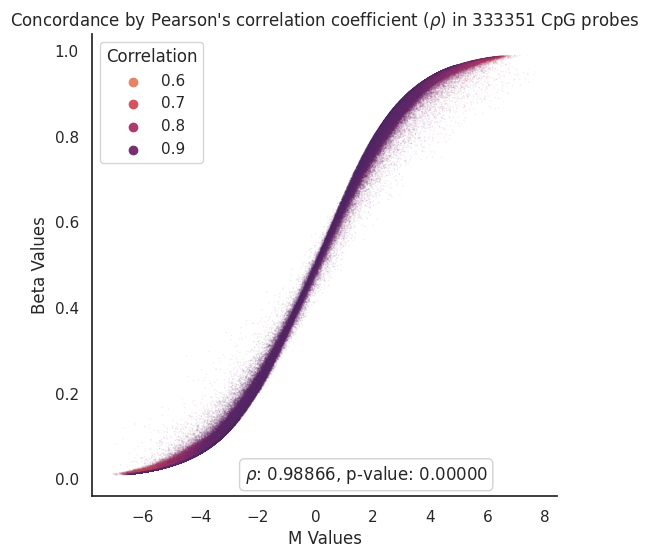

In [12]:
# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df_methyl_filtered, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df_methyl_filtered.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
                 bbox_inches='tight', dpi=300)

    return(plt.show())
draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

In [15]:
x_train_m.to_pickle(output_path + 'x_train_m.pkl')
df3.to_pickle(output_path + 'df3.pkl')

# read files
x_train_m = pd.read_pickle(output_path + 'x_train_m.pkl')
df3 = pd.read_pickle(output_path + 'df3.pkl')

## Run EWAS unadjusted with overall survival as outcome

In [13]:
import methylize

ewasOS_un = methylize.diff_meth_pos(meth_data=x_train_m,
                                    pheno_data=df3['os.time'],
                                    covariates=False,
                                    regression_method="linear",
                                    export='pkl',
                                    verbose=True,
                                    filename=output_path + 'ewas_cog_os_unadjusted')

# ewasOS_un = pd.read_pickle('../Data/EWAS_Results/ewas_cog_os_unadjusted.pkl')

Probes: 100%|██████████| 333351/333351 [01:00<00:00, 5472.34it/s]


Saved ../Data/Processed_Data/ewas_cog_os_unadjusted.


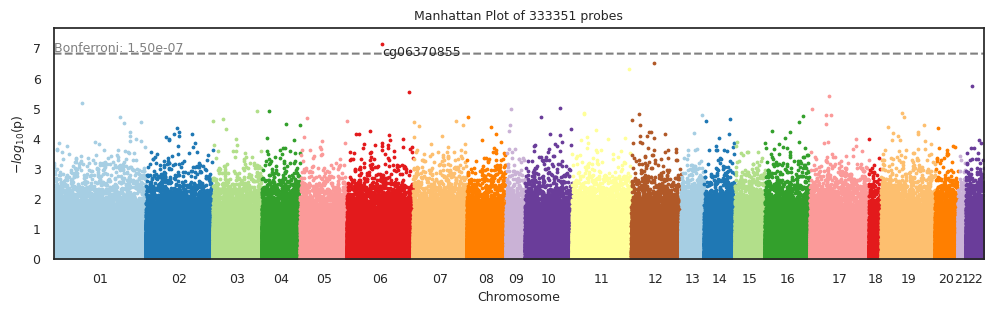

In [14]:
import seaborn as sns
sns.set_theme(style="white")

methylize.manhattan_plot(stats_results=ewasOS_un,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=3,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


## Save Files

In [8]:
output = df3.join(df_methyl,how='left') # Join clinical data with methyl data

x = output.iloc[:,df3.shape[1]+1:] # Select only methyl data
y = output.iloc[:,0:df3.shape[1]+1] # Select only clinical data

In [9]:
# Split train and test by clinical trial
y_train = y[~y['Clinical Trial'].isin(['AML02', 'AML08'])]
# y_train = y_train[y_train['Sample Type'].isin(['Diagnosis',
#        'Primary Blood Derived Cancer - Bone Marrow', 'Bone Marrow Normal',
#        'Primary Blood Derived Cancer - Peripheral Blood',
#        'Blood Derived Normal'])]

y_test = y[y['Clinical Trial'].isin(['AML02', 'AML08'])]

# Select samples in x that are in y_train
x_train = x.loc[y_train.index]
x_test = x.loc[y_test.index]

# x_train = pd.concat([x_train, ctrl_x], axis=0)
# y_train = pd.concat([y_train, ctrl_y], axis=0,keys=['Diagnosis','Control'], names=['sample_type'])


print(
    f"Discovery dataset (train) contains {x_train.shape[1]} rows (5mC sites) and {x_train.shape[0]} columns (samples)")
print(
    f"\n{y_train['Clinical Trial'].value_counts(dropna=False).to_string()}\n")
print(
    f"Validation dataset (test) contains {x_test.shape[1]} rows (5mC sites) and {x_test.shape[0]} columns (samples).")
print(f"\n{y_test['Clinical Trial'].value_counts(dropna=False).to_string()}\n")


Discovery dataset (train) contains 310545 rows (5mC sites) and 1142 columns (samples)

AAML1031    520
AAML0531    508
AML05        64
AAML03P1     36
CCG2961      14

Validation dataset (test) contains 310545 rows (5mC sites) and 204 columns (samples).

AML02    162
AML08     42



### Save Control and Relapse Data Separately

In [13]:
controls = df_[df_['Sample Type'].isin(['Bone Marrow Normal'])]

relapse = df_[df_['Sample Type'].isin(['Relapse', 'Recurrent Blood Derived Cancer - Bone Marrow',
                                       'Recurrent Blood Derived Cancer - Peripheral Blood'])]

# Merge control and relapse samples
t = pd.concat([controls, relapse], axis=0, join='outer',
              names=['Control', 'Relapse'])

# Join clinical data with methyl data
t2 = df_methyl.join(t, how='right')

# Save merged control and relapse samples
t2.to_pickle(output_path+'control_relapse.pkl')

print(
    f'Successfuly saved {controls.shape[0]} control samples and {relapse.shape[0]} relapse samples.\nPath: {output_path}')


Successfuly saved 147 control samples and 248 relapse samples.
Path: ../Data/Processed_Data/


## Watermark

In [14]:
%load_ext watermark

In [15]:
# produce a list of the loaded modules
%watermark -v -p pandas

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.3.0

pandas: 1.5.3

